In [92]:
import numpy as np
from scipy.optimize import minimize
from scipy.linalg import cholesky, cho_solve
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from matplotlib import cm
# from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [40]:
class GPR2:
        
    def __init__(self, optimize, optimizer, n_restarts_optimizer):
        self.optimize = optimize
        self.optimizer = optimizer
        self.n_restarts_optimizer = n_restarts_optimizer
        self.params = {"l": 0.5, "sigma_f": 0.3}

    def squared_exponential_kernel(self, x1, x2):
        """Compute squared-exponential kernel function"""
        dist_matrix = np.sum(x1**2, 1).reshape(-1, 1) + np.sum(x2**2, 1) - 2 * np.dot(x1, x2.T)
        return self.params["sigma_f"] ** 2 * np.exp(-0.5 / self.params["l"] ** 2 * dist_matrix)
    
    def fit(self, X, y):
        """GP model trainning"""
        self.train_X = np.asarray(X)
        self.train_y = np.asarray(y)

        def negative_log_likelihood_loss(params):
            """Hyperparameter optimization (RBF: l, sigma_f)"""
            self.params["l"] = params[0]
            self.params["sigma_f"] = params[1]

            Kyy = self.squared_exponential_kernel(self.train_X, self.train_X) + 1e-8*np.eye(len(self.train_X))
            lower = True
            L = cholesky(Kyy,lower=lower)
            self.alpha_ = cho_solve((L,lower),self.train_y)
            self.L_ = L

            # neg_log_likelihood_loss = 0.5*self.train_y.T.dot(np.linalg.inv(Kyy)).dot(self.train_y) + 0.5 * np.linalg.slogdet(Kyy)[1] + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            neg_log_likelihood_loss = 0.5*self.train_y.T.dot(self.alpha_) + 2*np.sum(np.log(np.diag(self.L_))) + 0.5 * len(self.train_X) * np.log(2 * np.pi)
            return neg_log_likelihood_loss.ravel()
        
        if self.optimize == True:
            res = minimize(negative_log_likelihood_loss, [self.params["l"], self.params["sigma_f"]], bounds=((1e-4, 1e4), (1e-4, 1e4)), method=self.optimizer)
            self.params["l"] = res.x[0]
            self.params["sigma_f"] = res.x[1]
    
    def predict(self, test_X):
        """GP model predicting"""
        X = np.asarray(test_X)
        # Kff = self.squared_exponential_kernel(self.train_X, self.train_X)  # (N, N)
        # Kyy = self.squared_exponential_kernel(X, X)  # (k, k)
        # Kfy = self.squared_exponential_kernel(self.train_X, X)  # (N, k)
        # Kff_inv = np.linalg.inv(Kff + 1e-8 * np.eye(len(self.train_X)))  # (N, N)
        
        # mu = Kfy.T.dot(Kff_inv).dot(self.train_y)
        # cov = Kyy - Kfy.T.dot(Kff_inv).dot(Kfy)
        
        Kfy = self.squared_exponential_kernel(self.train_X, X)
        Kyy = self.squared_exponential_kernel(X, X)  # (k, k)
        mu = Kfy.T.dot(self.alpha_)
        lower = True
        v = cho_solve((self.L_, lower),Kfy)
        cov = Kyy - Kfy.T.dot(v)

        return mu, cov
    

[[ 1.44772437e-01  1.33475748e-01  1.20606429e-01 ... -4.48324460e-05
  -4.39270400e-05 -4.22855893e-05]
 [ 1.33475748e-01  1.23594424e-01  1.12150827e-01 ... -4.55515848e-05
  -4.46317178e-05 -4.29639831e-05]
 [ 1.20606429e-01  1.12150827e-01  1.02188099e-01 ... -4.53977861e-05
  -4.44810943e-05 -4.28190418e-05]
 ...
 [-4.48324460e-05 -4.55515848e-05 -4.53977861e-05 ...  8.88802272e-02
   9.87295847e-02  1.07170043e-01]
 [-4.39270400e-05 -4.46317178e-05 -4.44810943e-05 ...  9.87295847e-02
   1.10143268e-01  1.20083360e-01]
 [-4.22855893e-05 -4.29639831e-05 -4.28190418e-05 ...  1.07170043e-01
   1.20083360e-01  1.31504495e-01]]


LinAlgError: When `allow_singular is False`, the input matrix must be symmetric positive definite.

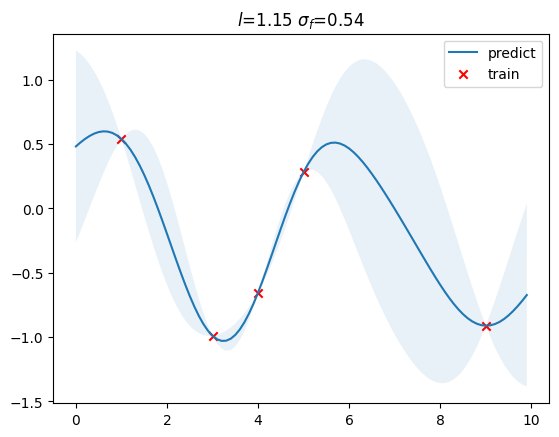

In [94]:
def y(x, noise_sigma=0.0):
    x = np.asarray(x)
    y = np.cos(x) + np.random.normal(0, noise_sigma, size=x.shape)
    return y.tolist()

train_X = np.array([3, 1, 4, 5, 9]).reshape(-1, 1)
train_y = y(train_X, noise_sigma=1e-4)
test_X = np.arange(0, 10, 0.1).reshape(-1, 1)

gpr2 = GPR2(True,'L-BFGS-B',0)
gpr2.fit(train_X, train_y)
mu, cov = gpr2.predict(test_X)
test_y = mu.ravel()
# print(test_y)
print(cov)
uncertainty = 1.96 * np.sqrt(np.diag(cov))
plt.figure()
plt.title(r"$l$=%.2f $\sigma_f$=%.2f" % (gpr2.params["l"], gpr2.params["sigma_f"]))
plt.fill_between(test_X.ravel(), test_y + uncertainty, test_y - uncertainty, alpha=0.1)
plt.plot(test_X, test_y, label="predict")
plt.scatter(train_X, train_y, label="train", c="red", marker="x")
plt.legend()
plt.savefig('./images/1d-regression-1')

mvn = multivariate_normal(mu.ravel(), cov)
print(mvn.cdf(np.asarray([0])))
z = mvn.cdf(np.asarray([np.inf]))- mvn.cdf(np.asarray([0]))
print(z)

In [65]:
from scipy.stats import multivariate_normal
 
mvn = multivariate_normal(mean=1, cov=0.5)
print(mvn.cdf(np.asarray([0])))
z = mvn.cdf(np.asarray([np.inf]))- mvn.cdf(np.asarray([0]))
print(z)
# fig1 = plt.figure()
# ax = fig1.add_subplot(111)
# ax.plot(x, z)
# plt.show()

0.0786496035251426
0.9213503964748574
